In [1]:
from torch.utils.data import DataLoader
import torch
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt
import torch.optim as optim
import torch.nn as nn
from vit_pytorch import ViT
from matplotlib.ticker import MaxNLocator
import time
from matplotlib import pyplot as plt
from IPython.display import clear_output
from common import *

torch.manual_seed(0)


_train_val_set = datasets.CIFAR10(
    root=CIFAR_PATH,
    train=True,
    download=False,
    transform=ToTensor()
)
test_set = datasets.CIFAR10( # Will not be used here just testing classes and size
    root=CIFAR_PATH,
    train=False,
    download=False,
    transform=ToTensor()
)
assert _train_val_set.classes == test_set.classes

classes = _train_val_set.classes
train_set, val_set = torch.utils.data.random_split(_train_val_set, [45000, 5000])

print(f"{'Classes:':<12} {classes}")
print(f"{'Train:':<12} {len(train_set):>5}")
print(f"{'Validation:':<12} {len(val_set):>5}")
print(f"{'Test:':<12} {len(test_set):>5}")
del _train_val_set
del test_set




Classes:     ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train:       45000
Validation:   5000
Test:        10000


## Show sample from the dataset

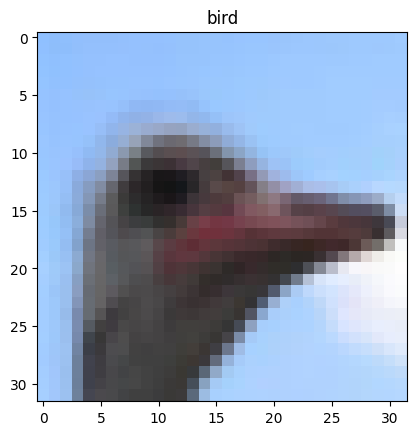

In [2]:
img, class_idx = train_set[7]
plt.imshow(torch.moveaxis(img, 0, -1))
plt.title(classes[class_idx])
plt.show()

## Create & Train Networks
Create stock ViT networks with different configurations and also custom variants with extra convolution layers. Train each network on the Cifar10 dataset and evaluate train & validation loss every epoch.

The model is evaluated on training data every epoch to ensure the reduction and training of individual mini-batches itself does not affect the result. It may be redundant but processing data when training is turned off is a lot faster.

The raw loss values including reduced running loss from training and graphs are saved and will be used during multiple model analysis/comparison and final report.

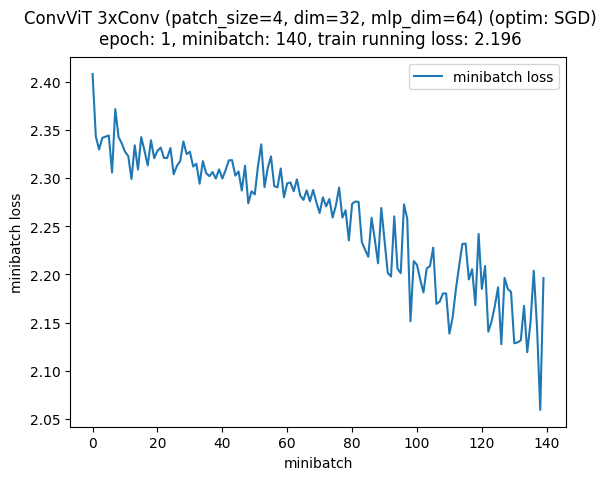

epoch: 1, mini batch 140/176: 2.1535532474517822
epoch: 1, mini batch 141/176: 2.2050700187683105
epoch: 1, mini batch 142/176: 2.1278183460235596
epoch: 1, mini batch 143/176: 2.1318182945251465
epoch: 1, mini batch 144/176: 2.124227523803711
epoch: 1, mini batch 145/176: 2.140995502471924
epoch: 1, mini batch 146/176: 2.161940574645996
epoch: 1, mini batch 147/176: 2.103390693664551
epoch: 1, mini batch 148/176: 2.16613507270813


KeyboardInterrupt: 

In [5]:
PRINT_INTERVAL = 10
EPOCHS = 30 
BATCH_SIZE = 256 
VAL_BATCH_SIZE = 2048
N_CLASSES = len(classes)

torch.manual_seed(10)

device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)

train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)

val_loader = DataLoader(
    val_set,
    batch_size=VAL_BATCH_SIZE,
    shuffle=False,
    num_workers=2,
)


class Configuration:
    def __init__(self, name, net, description):
        self.name = name
        self.net = net
        self.description = description

    @staticmethod
    def from_tuple(name, net_params):
        net, description = net_params
        return Configuration(name, net, description)


def create_basic_vit(
        num_classes,
        image_size,
        patch_size,
        dim,
        depth,
        heads,
        mlp_dim,
        dropout,
        emb_dropout,
        channels=3
):
    net = ViT(
        num_classes=num_classes,
        image_size=image_size,
        patch_size=patch_size,
        dim=dim,
        depth=depth,
        heads=heads,
        mlp_dim=mlp_dim,
        dropout=dropout,
        emb_dropout=emb_dropout,
        channels=channels
    )

    params = {
        "num_classes": num_classes,
        "image_size": image_size,
        "patch_size": patch_size,
        "dim": dim,
        "depth": depth,
        "heads": heads,
        "mlp_dim": mlp_dim,
        "dropout": dropout,
        "emb_dropout": emb_dropout,
    }

    return net, params


class ConvViT(nn.Module):
    def __init__(
            self,
            convolutions,
            num_classes,
            image_size=256,
            patch_size=32,
            dim=1024,
            depth=6,
            heads=8,
            mlp_dim=2048,
            dropout=0.1,
            emb_dropout=0.1
    ):
        super().__init__()
        modules = []
        channels = 3
        output_channels = 3
        for conv in range(convolutions):
            output_channels = 2 * channels
            modules.append(nn.Conv2d(channels, output_channels, 3, padding=1, padding_mode="zeros"))
            modules.append(nn.MaxPool2d((2, 2)))
            modules.append(nn.ReLU())
            channels = output_channels

        self.conv_part = nn.Sequential(*modules)

        vit_net, description = create_basic_vit(
            num_classes=num_classes,
            image_size=image_size // 2 ** channels,
            patch_size=patch_size,
            dim=dim,
            depth=depth,
            heads=heads,
            mlp_dim=mlp_dim,
            dropout=dropout,
            emb_dropout=emb_dropout,
            channels=output_channels
        )
        self.description = description
        self.vit_net = vit_net

    def forward(self, x):
        convoluted = self.conv_part(x)
        logits = self.vit_net(convoluted)
        return logits


conv_vit_a = ConvViT(
    convolutions=2,
    image_size=32,
    patch_size=2,
    dim=32,
    depth=6,
    heads=8,
    mlp_dim=64,
    dropout=0.1,
    emb_dropout=0.1,
    num_classes=N_CLASSES
)

conv_vit_b = ConvViT(
    convolutions=2,
    image_size=32,
    patch_size=4,
    dim=32,
    depth=6,
    heads=8,
    mlp_dim=64,
    dropout=0.1,
    emb_dropout=0.1,
    num_classes=N_CLASSES
)

conv_vit_c = ConvViT(
    convolutions=3,
    image_size=32,
    patch_size=2,
    dim=32,
    depth=6,
    heads=8,
    mlp_dim=64,
    dropout=0.1,
    emb_dropout=0.1,
    num_classes=N_CLASSES
)

conv_vit_d = ConvViT(
    convolutions=3,
    image_size=32,
    patch_size=4,
    dim=32,
    depth=6,
    heads=8,
    mlp_dim=64,
    dropout=0.1,
    emb_dropout=0.1,
    num_classes=N_CLASSES
)

models = [
    Configuration.from_tuple(
        "ViT (patch_size=4, dim=1024, mlp_dim=2048)", create_basic_vit(
            image_size=32,
            patch_size=4,
            dim=1024,
            depth=6,
            heads=8,
            mlp_dim=2048,
            dropout=0.1,
            emb_dropout=0.1,
            num_classes=N_CLASSES
        )
    ),
    Configuration.from_tuple(
        "ViT (patch_size=4, dim=128, mlp_dim=256)", create_basic_vit(
            image_size=32,
            patch_size=4,
            dim=128,
            depth=6,
            heads=8,
            mlp_dim=256,
            dropout=0.1,
            emb_dropout=0.1,
            num_classes=N_CLASSES
        )
    ),
    Configuration.from_tuple(
        "ViT (patch_size=4, dim=64, mlp_dim=128)", create_basic_vit(
            image_size=32,
            patch_size=4,
            dim=64,
            depth=6,
            heads=8,
            mlp_dim=128,
            dropout=0.1,
            emb_dropout=0.1,
            num_classes=N_CLASSES
        )
    ),
    Configuration.from_tuple(
        "ViT (patch_size=2, dim=32, mlp_dim=64)", create_basic_vit(
            image_size=32,
            patch_size=2,
            dim=32,
            depth=6,
            heads=8,
            mlp_dim=64,
            dropout=0.1,
            emb_dropout=0.1,
            num_classes=N_CLASSES
        )
    ),
    Configuration.from_tuple(
        "ViT (patch_size=4, dim=32, mlp_dim=64)", create_basic_vit(
            image_size=32,
            patch_size=4,
            dim=32,
            depth=6,
            heads=8,
            mlp_dim=64,
            dropout=0.1,
            emb_dropout=0.1,
            num_classes=N_CLASSES
        )
    ),
    Configuration(
        "ConvViT 2xConv (patch_size=2, dim=32, mlp_dim=64)",
        conv_vit_a,
        conv_vit_a.description
    ),
    Configuration(
        "ConvViT 2xConv (patch_size=4, dim=32, mlp_dim=64)",
        conv_vit_b,
        conv_vit_b.description
    ),
    Configuration(
        "ConvViT 3xConv (patch_size=2, dim=32, mlp_dim=64)",
        conv_vit_c,
        conv_vit_c.description
    ),
    Configuration(
        "ConvViT 3xConv (patch_size=4, dim=32, mlp_dim=64)",
        conv_vit_d,
        conv_vit_d.description
    ),
]


def one_hot(batched_label_indices, num_classes):
    batch_size = batched_label_indices.shape[0]
    target = torch.zeros((batch_size, num_classes))

    for sample in range(batch_size):
        target[sample, batched_label_indices[sample]] = 1

    return target


def eval_model(net, dataloader, criterion):
    with torch.no_grad():
        net.eval()

        running_loss = 0
        processed_samples = 0
        for i, data in enumerate(dataloader):
            inputs, labels = data
            processed_samples += inputs.shape[0]
            # print(f"Eval: {processed_samples}/{len(dataloader.dataset)}")

            inputs = inputs.to(device)
            target = one_hot(labels, N_CLASSES).to(device)
            del labels

            outputs = net(inputs)
            assert outputs.shape == target.shape

            loss = criterion(outputs, target)
            running_loss += loss.item()

        return running_loss / len(dataloader)



for optim_name in ["SGD", "AdamW"]:
    import copy
    local_models = copy.deepcopy(models)
    
    while len(local_models) > 0:
        model = local_models.pop()
        model.description["name"] = model.description
        print(model.name)
        
        epoch_run_times = []
        epoch_val_losses = []
        epoch_train_losses = []
        epoch_running_train_losses = []

        minibatch_losses = []

        net = model.net
        net.to(device)

        criterion = nn.CrossEntropyLoss().to(device)
        if "SGD" in optim_name:
            optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
        else:
            optimizer = optim.AdamW(net.parameters(), lr=0.001)

        for epoch in range(EPOCHS):
            epoch_running_loss = 0.0
            start_time = time.time()
            for i, data in enumerate(train_loader):
                inputs, class_indices = data

                inputs = inputs.to(device)
                target = one_hot(class_indices, N_CLASSES).to(device)

                optimizer.zero_grad()
                net.train()

                # Forward
                outputs = net(inputs)
                assert outputs.shape == target.shape
                # Backward
                loss = criterion(outputs, target)
                loss.backward()
                # Optimize
                optimizer.step()

                epoch_running_loss += loss.item()

                minibatch_losses.append(loss.item())
                print(f"epoch: {epoch+1}, mini batch {i}/{len(train_loader)}: {loss.item()}")

                if (i + 1) % PRINT_INTERVAL == 0:
                    stat_text = f"{model.name} (optim: {optimizer.__class__.__name__})\nepoch: {epoch + 1:>2}, minibatch: {i + 1:>5}, last minibatch loss: {minibatch_losses[-1]:>7.3f}"
                    print(stat_text)

                    title = f"{model.name} (optim: {optimizer.__class__.__name__})\nepoch: {epoch + 1}, minibatch: {i + 1}, train running loss: {minibatch_losses[-1]:.3f}"

                    clear_output(wait=True)
                    fig, ax = plt.subplots(1, 1)
                    fig.suptitle(title)
                    ax.plot(minibatch_losses, label="minibatch loss")
                    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
                    ax.set_xlabel("minibatch")
                    ax.set_ylabel(f"minibatch loss")
                    ax.minorticks_off()
                    ax.legend()
                    plt.show()

            basename = f"{model.name.replace(' ', '_')}_{optimizer.__class__.__name__}"
            results_filename = f"assets/results/{basename}.csv"
            img_filename = f"assets/img/{basename}.png"
            img_reeval_filename = f"assets/img/{basename}_reeval.png"
            checkpoints_filename = f"assets/checkpoints/{basename}_epoch-{epoch + 1}.chkpt"
            description_filename = f"assets/checkpoints/{basename}.txt"
            minibatches_img_filename = f"assets/img/{basename}_minibatches_epoch-{epoch + 1}.png"

            title = f"{model.name}\noptim: {optimizer.__class__.__name__}\nepoch: {epoch + 1}, train loss: {minibatch_losses[-1]:.3f}"
            fig, ax = plt.subplots(1, 1)
            fig.suptitle(title)
            fig.subplots_adjust(top=0.84)
            ax.plot(minibatch_losses, label="minibatch loss")
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            ax.set_xlabel("minibatch")
            ax.set_ylabel(f"minibatch loss")
            ax.minorticks_off()
            ax.legend()
            plt.savefig(minibatches_img_filename)

            end_time = time.time()
            epoch_run_times.append(end_time - start_time)

            epoch_running_loss = epoch_running_loss / len(train_loader)
            epoch_running_train_losses.append(epoch_running_loss)

            reeval_train_loss = eval_model(net, train_loader, criterion)
            epoch_train_losses.append(reeval_train_loss)

            val_loss = eval_model(net, val_loader, criterion)
            epoch_val_losses.append(val_loss)

            import polars as pl

            df = pl.DataFrame({
                "name": [model.name] * len(epoch_val_losses),
                "optimizer": [optimizer.__class__.__name__] * len(epoch_val_losses),
                "epoch": list(range(1, len(epoch_val_losses) + 1)),
                "epoch_time": epoch_run_times,
                "training_averaged_minibatch_loss": epoch_running_train_losses,
                "train_set_loss": epoch_train_losses,
                "validation_set_loss": epoch_val_losses,
            })
            df.write_csv(results_filename)

            with open(description_filename, "w") as f:
                f.write(str(model.description))
            torch.save(model.net.state_dict(), checkpoints_filename)

            # print("val loss: ", val_losses[-1])
            stat_text = f"{model.name} (optim: {optimizer.__class__.__name__})\nepoch: {epoch + 1:>2}\n\train set loss:{reeval_train_loss:>7.3f}\n\tvalidation set loss: {val_loss:>7.3f}"
            print(stat_text)

            if len(epoch_train_losses) > 1:
                title = f"{model.name}\noptim: {optimizer.__class__.__name__}\ntrain loss: {reeval_train_loss:.3f}, validation loss: {val_loss:.3f}"

                fig, ax = plt.subplots(1, 1)
                fig.suptitle(title)
                fig.subplots_adjust(top=0.84)
                ax.plot(epoch_train_losses, label="train set loss")
                ax.plot(epoch_val_losses, label="validation set loss")
                ax.xaxis.set_major_locator(MaxNLocator(integer=True))
                ax.set_xlabel("epoch")
                ax.set_ylabel("loss")
                ax.minorticks_off()
                ax.legend()
                plt.savefig(img_filename)

                title = f"{model.name}\noptim: {optimizer.__class__.__name__}\ntrain loss: {reeval_train_loss:.3f}, train avg. minibatch loss: {epoch_running_loss:.3f}, validation loss: {val_loss:.3f}"
                fig.suptitle(title)
                ax.plot(epoch_running_train_losses, label="training averaged minibatch loss")
                ax.legend()
                plt.savefig(img_reeval_filename)
                plt.show()

        del model
        del net
        import gc

        gc.collect()
        torch.cuda.empty_cache()

print("Finished Training")


(Accidentally run the cell above)